# Решающие деревья. Практика

## Подготовка данных

Данные, с которыми мы сегодня работаем - экспертный рейтинг шоколадных батончиков: https://www.kaggle.com/datasets/rtatman/chocolate-bar-ratings

**Задача**: по разным характеристикам шоколадных батончиков предсказать их экспертный рейтинг

**Тип**: регрессия

Загрузим и посмотрим данные

In [6]:
import pandas as pd

path = './data/flavors_of_cacao.csv'
data = pd.read_csv(path)
data.head()

,Company (Maker-if known),Specific Bean Origin or Bar Name,REF,Review Date,Cocoa Percent,Company Location,Rating,Bean Type,Broad Bean Origin
0,A. Morin,Agua Grande,1876,2016,63%,France,3.75,,Sao Tome
1,A. Morin,Kpime,1676,2015,70%,France,2.75,,Togo
2,A. Morin,Atsane,1676,2015,70%,France,3.00,,Togo
3,A. Morin,Akata,1680,2015,70%,France,3.50,,Togo
4,A. Morin,Quilla,1704,2015,70%,France,3.50,,Peru


Посмотрим количество строк и столбцов

In [7]:
data.shape

(1795, 9)

Доля пропущенных значений в каждом из полей:

In [8]:
data.isna().mean(axis=0)

Company (Maker-if known)            0.000000
Specific Bean Origin or Bar Name    0.000000
REF                                 0.000000
Review Date                         0.000000
Cocoa Percent                       0.000000
Company Location                    0.000000
Rating                              0.000000
Bean Type                           0.000557
Broad Bean Origin                   0.000557
dtype: float64

Заведем 2 списка: в один будем записывать категориальные признаки, в другой - числовые

In [10]:
categorical_features = []
numerical_features = []

Предобрабатываем поле производителя:

In [12]:
company_stat = data['Company (Maker-if known)'].value_counts()
company_stat

Soma                 47
Bonnat               27
Fresco               26
Pralus               25
A. Morin             23
                     ..
Chocablog             1
Marigold's Finest     1
Chloe Chocolat        1
Chequessett           1
Ki' Xocolatl          1
Name: Company (Maker-if known), Length: 416, dtype: int64

In [13]:
data['company'] = data['Company (Maker-if known)'].apply(lambda x: x if company_stat[x] >= 18 else 'Other')
data['company'].value_counts()

Other                         1505
Soma                            47
Bonnat                          27
Fresco                          26
Pralus                          25
A. Morin                        23
Arete                           22
Domori                          22
Guittard                        22
Valrhona                        21
Hotel Chocolat (Coppeneur)      19
Coppeneur                       18
Mast Brothers                   18
Name: company, dtype: int64

In [14]:
categorical_features.append('company')

Предобрабатываем регион происхождения батончика:

In [15]:
origin_stat = data['Specific Bean Origin or Bar Name'].value_counts()
origin_stat

Madagascar                        57
Peru                              45
Ecuador                           42
Dominican Republic                37
Venezuela                         21
                                  ..
Conacado, #213, DR, -C             1
Sambirano Valley, #215, MR, MC     1
Chuao, #218, MR, MC                1
Chuao, #217, DR, MC                1
Brazil, Mitzi Blue                 1
Name: Specific Bean Origin or Bar Name, Length: 1039, dtype: int64

In [16]:
data['origin'] = data['Specific Bean Origin or Bar Name'].apply(lambda x: x if origin_stat[x] >= 18 else 'Other')
data['origin'].value_counts()

Other                 1555
Madagascar              57
Peru                    45
Ecuador                 42
Dominican Republic      37
Venezuela               21
Chuao                   19
Sambirano               19
Name: origin, dtype: int64

In [17]:
categorical_features.append('origin')

Предобрабатываем поля REF и Review Date:

In [18]:
numerical_features.extend(['REF', 'Review Date'])

Предобрабатываем процент содержания какао:

In [20]:
data['Cocoa Percent'].value_counts().sort_index()

100%      20
42%        1
46%        1
50%        1
53%        1
55%       16
56%        2
57%        1
58%        8
60%       43
60.5%      1
61%        8
62%       14
63%       12
64%       34
65%       78
66%       23
67%       27
68%       47
69%       10
70%      672
71%       31
72%      189
72.5%      4
73%       40
73.5%      2
74%       50
75%      222
76%       23
77%       33
78%       17
79%        1
80%       72
81%        5
82%       17
83%        4
84%        4
85%       36
86%        1
87%        1
88%        8
89%        2
90%        8
91%        3
99%        2
Name: Cocoa Percent, dtype: int64

In [21]:
data['cocoa'] = data['Cocoa Percent'].str[:-1].astype(float)

In [24]:
numerical_features.append('cocoa')

Предобрабатываем расположение компании-производителя:

In [25]:
location_stat = data['Company Location'].value_counts()
location_stat

U.S.A.               764
France               156
Canada               125
U.K.                  96
Italy                 63
Ecuador               54
Australia             49
Belgium               40
Switzerland           38
Germany               35
Austria               26
Spain                 25
Colombia              23
Hungary               22
Venezuela             20
Japan                 17
Brazil                17
Peru                  17
Madagascar            17
New Zealand           17
Denmark               15
Vietnam               11
Scotland              10
Guatemala             10
Israel                 9
Costa Rica             9
Argentina              9
Poland                 8
Lithuania              6
Honduras               6
South Korea            5
Nicaragua              5
Sweden                 5
Domincan Republic      5
Ireland                4
Netherlands            4
Fiji                   4
Sao Tome               4
Puerto Rico            4
Mexico                 4


In [26]:
data['location'] = data['Company Location'].apply(lambda x: x if location_stat[x] >= 18 else 'Other')
data['location'].value_counts()

U.S.A.         764
Other          259
France         156
Canada         125
U.K.            96
Italy           63
Ecuador         54
Australia       49
Belgium         40
Switzerland     38
Germany         35
Austria         26
Spain           25
Colombia        23
Hungary         22
Venezuela       20
Name: location, dtype: int64

In [27]:
categorical_features.append('location')

Предобрабатываем широкий регион происхождения шоколадных бобов:

In [30]:
bean_stat = data['Broad Bean Origin'].value_counts(dropna=False)
bean_stat

Venezuela                214
Ecuador                  193
Peru                     165
Madagascar               145
Dominican Republic       141
                        ... 
Peru, Belize               1
Peru, Mad., Dom. Rep.      1
NaN                        1
PNG, Vanuatu, Mad          1
Venezuela, Carribean       1
Name: Broad Bean Origin, Length: 101, dtype: int64

In [31]:
data['bean_origin'] = data['Broad Bean Origin'].apply(lambda x: x if bean_stat[x] >= 18 else 'Other')
data['bean_origin'].value_counts()

Other                 232
Venezuela             214
Ecuador               193
Peru                  165
Madagascar            145
Dominican Republic    141
                       73
Nicaragua              60
Brazil                 58
Bolivia                57
Belize                 49
Papua New Guinea       42
Colombia               40
Vietnam                38
Costa Rica             38
Tanzania               34
Trinidad               33
Ghana                  33
Mexico                 30
Guatemala              28
Hawaii                 28
Domincan Republic      25
Jamaica                20
Grenada                19
Name: bean_origin, dtype: int64

In [32]:
categorical_features.append('bean_origin')

Предобрабатываем используемый тип бобов:

In [33]:
type_stat = data['Bean Type'].value_counts(dropna=False)
type_stat

                            887
Trinitario                  419
Criollo                     153
Forastero                    87
Forastero (Nacional)         52
Blend                        41
Criollo, Trinitario          39
Forastero (Arriba)           37
Criollo (Porcelana)          10
Trinitario, Criollo           9
Forastero (Parazinho)         8
Forastero (Arriba) ASS        6
Beniano                       3
Matina                        3
EET                           3
Nacional (Arriba)             3
Criollo, Forastero            2
Amazon, ICS                   2
Trinitario, Forastero         2
Amazon mix                    2
Forastero (Catongo)           2
Nacional                      2
Trinitario (85% Criollo)      2
Criollo (Amarru)              2
Criollo (Ocumare 61)          2
Criollo, +                    1
Forastero (Arriba) ASSS       1
Trinitario, TCGA              1
Trinitario (Amelonado)        1
Trinitario, Nacional          1
NaN                           1
Foraster

In [34]:
data['bean_type'] = data['Bean Type'].apply(lambda x: x if type_stat[x] >= 18 else 'Other')
data['bean_type'].value_counts()

                        887
Trinitario              419
Criollo                 153
Forastero                87
Other                    80
Forastero (Nacional)     52
Blend                    41
Criollo, Trinitario      39
Forastero (Arriba)       37
Name: bean_type, dtype: int64

In [35]:
categorical_features.append('bean_type')

Наши категориальные признаки записаны в столбцы:

In [36]:
categorical_features

['company', 'origin', 'location', 'bean_origin', 'bean_type']

Общее количество уникальных значений категориальных признаков следующее:

In [37]:
sum([data[feature].nunique() for feature in categorical_features])

70

Кодируем категориальные признаки с помощью one-hot-encoding:

In [38]:
from sklearn.preprocessing import OneHotEncoder


encoder = OneHotEncoder()
encoder.fit(data[categorical_features])

OneHotEncoder()

In [46]:
categories = []
for i, feature in enumerate(categorical_features):
    categories.extend([f'{feature}: {value}' for value in encoder.categories_[i]])

In [50]:
data.loc[:, categories] = encoder.transform(data[categorical_features]).toarray()

В итоге категориальные признаки имеет следующий вид:

## Построение модели

Делим данные на обучение и тест:

In [62]:
from sklearn.model_selection import train_test_split


features = numerical_features + categories
X = data[features]
y = data['Rating']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

Посмотрим как стратификация повлияла на распределения целевых признаков в обучающей и тестовой выборках

In [59]:
y_train.value_counts() / y_train.shape[0]

3.50    0.218153
3.00    0.190287
3.25    0.168790
2.75    0.144108
3.75    0.117038
2.50    0.070860
4.00    0.054936
2.00    0.017516
2.25    0.007962
1.50    0.005573
1.00    0.002389
1.75    0.001592
5.00    0.000796
Name: Rating, dtype: float64

In [60]:
y_test.value_counts() / y_test.shape[0]

3.50    0.218924
3.00    0.189239
3.25    0.168831
2.75    0.144712
3.75    0.116883
2.50    0.070501
4.00    0.053803
2.00    0.018553
2.25    0.007421
1.50    0.005566
5.00    0.001855
1.75    0.001855
1.00    0.001855
Name: Rating, dtype: float64

Инициализируем и обучаем модель с параметрами по умолчанию:

In [63]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor()
tree.fit(X_train, y_train)

DecisionTreeRegressor()

Для удобства создаем функцию, которая будет возвращать метрики сразу на обучающих и тестовых данных:

In [2]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

def get_metrics(model):
    results = []
    y_pred = model.predict(X_train)
    mae = mean_absolute_error(y_train, y_pred)
    mse = mean_squared_error(y_train, y_pred)
    results.append(['Train', mae, mse])
    y_pred = model.predict(X_test)
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    results.append(['Test', mae, mse])
    return pd.DataFrame(columns=['Group', 'MAE', 'MSE'], data=results)

С параметрами по умолчанию получили следующие метрики:

In [64]:
get_metrics(tree)

,Group,MAE,MSE
0,Train,0.008360,0.002405
1,Test,0.417517,0.291651


Сделаем подбор гиперпараметров по сетке c помощью кросс валидации:

![title](grid_search_cross_validation.png)
***Как работает кросс валидация:***

*При оценке модели имеющиеся в наличии данные разбиваются на k частей. Затем на k-1 частях данных производится обучение модели, а оставшаяся часть данных используется для тестирования. Процедура повторяется k раз; в итоге каждая из k частей данных используется для тестирования. В результате получается оценка эффективности выбранной модели с наиболее равномерным использованием имеющихся данных.*

In [66]:
from sklearn.model_selection import GridSearchCV


grid = {'criterion': ['absolute_error', 'squared_error'],
        'max_depth': [1, 2, 5, 10, None],
        'min_samples_leaf': [1, 2, 5, 10, 20, 100]}
search = GridSearchCV(tree, grid)
search.fit(X_train, y_train)

GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid={'criterion': ['absolute_error', 'squared_error'],
                         'max_depth': [1, 2, 5, 10, None],
                         'min_samples_leaf': [1, 2, 5, 10, 20, 100]})

In [68]:
tree = DecisionTreeRegressor(**search.best_params_)
tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, min_samples_leaf=20)

In [69]:
get_metrics(tree)

,Group,MAE,MSE
0,Train,0.351293,0.196502
1,Test,0.361941,0.204693


Обучим теперь модель с подобранными параметрами:

## Бонусы деревьев решений

Как говорили на лекции, деревья решений позволяют делать отбор признаков:

In [73]:
pd.DataFrame({'feature': features, 'importance': tree.feature_importances_}).sort_values('importance', ascending=False).iloc[:10]

,feature,importance
2,cocoa,0.495626
0,REF,0.209519
12,company: Other,0.162240
21,origin: Peru,0.111302
38,location: U.S.A.,0.021313
42,bean_origin: Brazil,0.000000
43,bean_origin: Colombia,0.000000
44,bean_origin: Costa Rica,0.000000
45,bean_origin: Domincan Republic,0.000000
46,bean_origin: Dominican Republic,0.000000


Кроме того, деревья хорошо интерпретируемы:

[Text(0.5, 0.8333333333333334, 'cocoa <= 90.5\nsquared_error = 0.228\nsamples = 1256\nvalue = 3.186'),
 Text(0.25, 0.5, 'company: Other <= 0.5\nsquared_error = 0.213\nsamples = 1237\nvalue = 3.199'),
 Text(0.125, 0.16666666666666666, 'squared_error = 0.174\nsamples = 202\nvalue = 3.363'),
 Text(0.375, 0.16666666666666666, 'squared_error = 0.214\nsamples = 1035\nvalue = 3.167'),
 Text(0.75, 0.5, 'REF <= 765.0\nsquared_error = 0.474\nsamples = 19\nvalue = 2.329'),
 Text(0.625, 0.16666666666666666, 'squared_error = 0.376\nsamples = 10\nvalue = 1.925'),
 Text(0.875, 0.16666666666666666, 'squared_error = 0.201\nsamples = 9\nvalue = 2.778')]

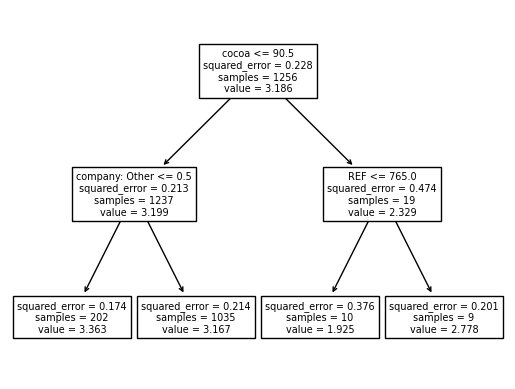

In [78]:
from sklearn.tree import plot_tree

tree = DecisionTreeRegressor(max_depth=2)
tree.fit(X_train, y_train)
plot_tree(tree, feature_names=features)

In [89]:
bar = {
    'REF': 1500,
    'Review Date': 2016,
    'company': 'Other',
    'origin': 'Ecuador',
    'location': 'Italy',
    'cocoa': 95,
    'bean_origin': 'Ecuador',
    'bean_type': 'Forastero (Arriba)'
}
bar = pd.DataFrame(bar, index=[0])
bar[categories] = encoder.transform(bar[categorical_features]).toarray().astype(int)

In [88]:
tree.predict(bar[features])

array([3.16666667])

In [90]:
tree.predict(bar[features])

array([2.77777778])